<a href="https://colab.research.google.com/github/kkt86/nlp-notebooks/blob/master/fastai_nlp_2_3_svd_nmf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)

# Look at the data

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 
              'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
print(newsgroups_train.filenames.shape)
print(newsgroups_train.target.shape)
print(newsgroups_train.data[0])

(2034,)
(2034,)
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


In [5]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

In [0]:
num_topics = 6
num_top_words = 8

# Stop words, stemming, lemmatization

In [7]:
from sklearn.feature_extraction import stop_words

sorted(list(stop_words.ENGLISH_STOP_WORDS)[:20])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


['amount',
 'as',
 'be',
 'can',
 'cry',
 'done',
 'either',
 'had',
 'i',
 'ie',
 'next',
 'no',
 'our',
 'rather',
 'themselves',
 'therefore',
 'thru',
 'whither',
 'whoever',
 'within']

In [8]:
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [9]:
from nltk import stem

wnl = stem.WordNetLemmatizer()
porter = stem.PorterStemmer()

word_list = ["feet", "foot", "foots", "footing"]

print([wnl.lemmatize(word) for word in word_list])
print([porter.stem(word) for word in word_list])

['foot', 'foot', 'foot', 'footing']
['feet', 'foot', 'foot', 'foot']


### Data Processing

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
vectorizer = CountVectorizer(stop_words="english")
vectors = vectorizer.fit_transform(newsgroups_train.data)
vocab = np.array(vectorizer.get_feature_names())

print(vectors.shape)
print(len(newsgroups_train.data))
print(len(vocab))

(2034, 26576)
2034
26576


## SVD

In [12]:
#from scipy.sparse.linalg import sv
%time
U, s, Vh = linalg.svd(vectors.todense(), full_matrices=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [13]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [14]:
# assert that norm of original and recomposed matrix are the same
recomposed = U @ np.diag(s)@ Vh
np.linalg.norm( vectors.todense() - recomposed)

3.0400655704971045e-12

In [15]:
# confirm that U and Vh are orthonormal

print(np.linalg.norm(np.eye(U.shape[0]) - U @ U.T) )
print(np.linalg.norm(np.eye(Vh.shape[0]) - Vh @ Vh.T)) 

1.7355800888104085e-13
1.7840977578250578e-13


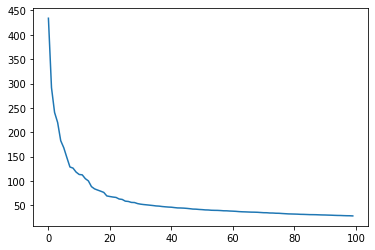

In [19]:
plt.plot(s[:100])

In [21]:
# check out topics
num_top_words = 8

def show_topics(a):
  top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words -1: -1]]
  topic_words = ([top_words(t) for t in a])
  return [" ".join(t) for t in topic_words]

show_topics(Vh[:5])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']

In [24]:
np.argsort(Vh[0])

array([13816, 12642,  8956, ..., 19210,  7181,  8462])

## Non-negative Matrix Factorization (NMF)

In [25]:
m, n = vectors.shape
d = 5 # number of topics

print(m,n)

2034 26576


In [0]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=d, random_state=1)

W1 = nmf.fit_transform(vectors)
H1 = nmf.components_

In [33]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [0]:
from keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()
matrix_data = x_test.reshape((28*28,10000))
nmf_mnist = NMF(n_components=10, random_state=123)
W1 = nmf_mnist.fit_transform(matrix_data)
H1 = nmf_mnist.components_

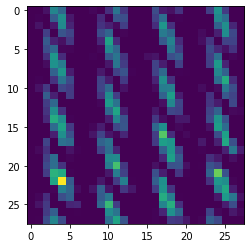

In [72]:
plt.imshow(W1[:,5].reshape(28,28))

### TF-IDF

In [0]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
vectors_tfidf = tfidf_vectorizer.fit_transform(newsgroups_train.data)

In [77]:
vectors_tfidf

<2034x26576 sparse matrix of type '<class 'numpy.float64'>'
	with 133634 stored elements in Compressed Sparse Row format>